In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [2]:
# Connect to google drive
in_colab = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/My Drive/Capstone/Project_2")
    in_colab = True
except:
    pass

Mounted at /content/drive


In [3]:
def load_data(filepath):
    '''
    load one-hot encoded data prepared in the exploratory data analysis script.
    '''
    df = pd.read_excel(filepath)

    # copy to maintain original information - unscaled
    df_copy = df.copy()
    df = df.drop(["Unnamed: 0", 'pdays'], axis=1, errors='ignore')
    
    return df, df_copy

df, df_copy = load_data('Data/one_hot.xlsx')
df.head()

,age,duration,campaign,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0


### Prepare Data for Modeling

In [4]:
# separate features from labels
X = df.drop('y', axis=1)
y = df['y']

# separate training data and non-training data - stratify to maintain ratio
# of imbalanced labels
X_train, X_remain, y_train, y_remain = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# split non-training data into validation and test sets - stratify to maintain 
# ratio of imbalanced labels
X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size=0.50, random_state=42, stratify=y_remain)

In [5]:
# Scale the numeric data to have mean 0 standard deviation 1

cols_to_scale = ['age', 'duration', 'empvarrate', 'conspriceidx', 'consconfidx', 'euribor3m', 'nremployed']

scaler = StandardScaler()

# fit and transform training data
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# transform validation and test data
X_valid[cols_to_scale] = scaler.transform(X_valid[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [6]:
X_train.head()

,age,duration,campaign,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,year,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
7309,0.961016,-0.408114,2,0,0.648136,0.722717,0.887472,0.714873,0.332204,2008,...,0,0,0,0,1,0,0,0,1,0
4169,1.057229,-0.384959,5,0,0.648136,0.722717,0.887472,0.713720,0.332204,2008,...,0,0,0,1,0,0,0,0,1,0
35810,0.576165,-0.168849,2,0,-1.198744,-1.181025,-1.231784,-1.368338,-0.935879,2009,...,0,0,0,1,0,0,0,0,1,0
9668,0.576165,-0.902081,1,0,0.839193,1.537124,-0.280281,0.773060,0.844128,2008,...,0,0,0,1,0,0,0,0,1,0
34389,-1.444302,1.498288,5,0,-1.198744,-1.181025,-1.231784,-1.355664,-0.935879,2009,...,0,0,0,0,1,0,0,0,1,0


### Logistic Regression - Out of Box

In [7]:
def confirm_data_splits():
    pass

y_train.value_counts()
y_valid.value_counts()
y_test.value_counts()

no     5483
yes     696
Name: y, dtype: int64

In [8]:
clf = LogisticRegression(random_state=0, solver='newton-cholesky', max_iter=5000).fit(X_train, y_train)

In [9]:
valid_predictions = clf.predict(X_valid)
valid_predictions

array(['no', 'no', 'yes', ..., 'no', 'no', 'no'], dtype=object)

In [10]:
def print_accuracy(model, features, y_true):

    acc_score = model.score(features, y_true)
    print(f"Model Accuracy: {np.round(acc_score, 3)}")


def print_metrics(y_true, y_preds):

    # precision scores
    precision_mac = precision_score(y_true, y_preds, average='macro')
    precision_mic = precision_score(y_true, y_preds, average='micro')
    precision_weighted = precision_score(y_true, y_preds, average='weighted')

    print(f"Macro Precision: {np.round(precision_mac, 3)}")
    print(f"Micro Precision: {np.round(precision_mic, 3)}")
    print(f"Weighted Precision: {np.round(precision_weighted, 3)}")

    # recall scores
    recall_mac = recall_score(y_true, y_preds, average='macro')
    recall_mic = recall_score(y_true, y_preds, average='micro')
    recall_weighted = recall_score(y_true, y_preds, average='weighted')

    print(f"Macro Recall: {np.round(recall_mac, 3)}")
    print(f"Micro Recall: {np.round(recall_mic, 3)}")
    print(f"Weighted Recall: {np.round(recall_weighted, 3)}")

    # f1 scores
    f1_mac = f1_score(y_true, y_preds, average='macro')
    f1_mic = f1_score(y_true, y_preds, average='micro')
    f1_weighted = f1_score(y_true, y_preds, average='weighted')

    print(f"Macro f1: {np.round(f1_mac, 3)}")
    print(f"Micro f1: {np.round(f1_mic, 3)}")
    print(f"Weighted f1: {np.round(f1_weighted, 3)}")

In [11]:
print_accuracy(clf, X_valid, y_valid)

Model Accuracy: 0.912


In [12]:
print_metrics(y_valid, valid_predictions)

Macro Precision: 0.808
Micro Precision: 0.912
Weighted Precision: 0.901
Macro Recall: 0.692
Micro Recall: 0.912
Weighted Recall: 0.912
Macro f1: 0.731
Micro f1: 0.912
Weighted f1: 0.902


We use macro average scores when we need to treat all classes equally to evaluate the overall performance of the classifier against the most common class labels. Therefore, in this case we consider macro-metrics.

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'none'],
#     'C' : np.logspace(-4, 4, 10),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     }
# ]
param_grid = [    
    {'penalty' : ['l1','l2','none'],
    'C' : np.logspace(-4, 4, 3),
    'solver' : ['lbfgs','liblinear'],
    }
]

In [ ]:
logModel = LogisticRegression()

In [ ]:
print(logModel.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [ ]:
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [ ]:
best_clf = clf.fit(X,y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbf

In [ ]:
best_clf.best_estimator_

LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')

In [ ]:
print (f'Accuracy - : {best_clf.score(X,y):.3f}')

Accuracy - : 0.894


In [ ]:
valid_predictions = best_clf.predict(X_valid)

In [ ]:
print_metrics(y_valid, valid_predictions)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.056
Micro Precision: 0.113
Weighted Precision: 0.013
Macro Recall: 0.5
Micro Recall: 0.113
Weighted Recall: 0.113
Macro f1: 0.101
Micro f1: 0.113
Weighted f1: 0.023


### ROC AUC

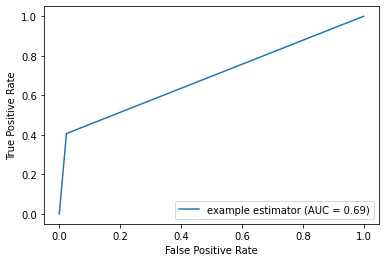

In [ ]:
### Change 'yes' 'no' to 1, 0
valid_binary = list(y_valid.replace("no", 0).replace("yes", 1))
valid_binary_preds = list(pd.Series(valid_predictions).replace("no", 0).replace("yes", 1))

# sklearn function to display ROC curve
fpr, tpr, thresholds = metrics.roc_curve(valid_binary, valid_binary_preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

### Confusion Matrix

In [13]:
cm = metrics.confusion_matrix(y_valid, valid_predictions)
# print(cm)

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions


def show_confusion_matrix(y_true, y_preds):

    binary_true = list(y_true.replace("no", 0).replace("yes", 1))
    binary_preds = list(pd.Series(y_preds).replace("no", 0).replace("yes", 1))

    ConfusionMatrixDisplay.from_predictions(
    binary_true, binary_preds)

    plt.xticks(ticks = [0, 1], labels = ['No', 'Yes'])
    plt.yticks(ticks = [0, 1], labels = ['No', 'Yes'])

    plt.title("Confusion Matrix")
    plt.show()

    print("\n---------------------------------------\n")

    ConfusionMatrixDisplay.from_predictions(
    binary_true, binary_preds, normalize='true')

    plt.xticks(ticks = [0, 1], labels = ['No', 'Yes'])
    plt.yticks(ticks = [0, 1], labels = ['No', 'Yes'])

    plt.title("Confusion Matrix")
    plt.show()

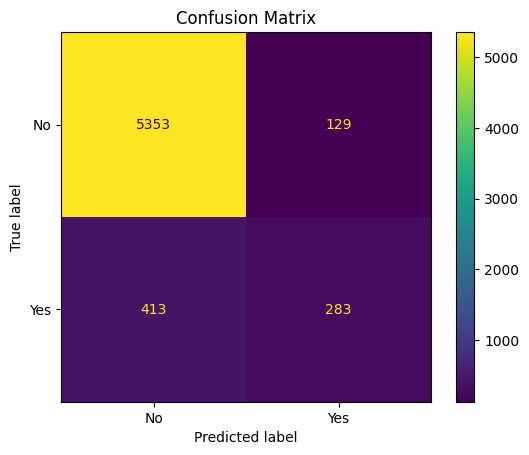


---------------------------------------



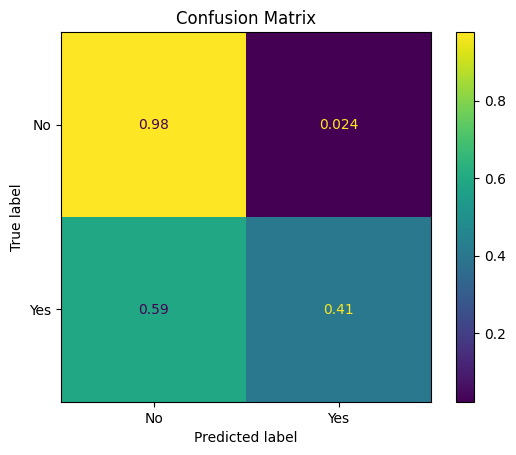

In [15]:
show_confusion_matrix(y_valid, valid_predictions)

## Support Vector Classifier - Out of Box

In [ ]:
model = SVC()
model.fit(X_train, y_train)

svc_valid_preds = model.predict(X_valid)

In [ ]:
print_metrics(y_valid, svc_valid_preds)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.444
Micro Precision: 0.887
Weighted Precision: 0.787
Macro Recall: 0.5
Micro Recall: 0.887
Weighted Recall: 0.887
Macro f1: 0.47
Micro f1: 0.887
Weighted f1: 0.834


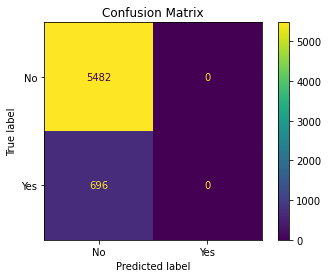


---------------------------------------



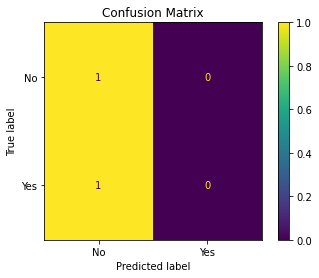

In [ ]:
show_confusion_matrix(y_valid, svc_valid_preds)

In [ ]:
param_grid = { 'C':[0.1,1,10],'kernel':['rbf','sigmoid','linear'],'degree':[2,3,4]}
grid = GridSearchCV(SVC(),param_grid)

In [ ]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'kernel': ['rbf', 'sigmoid', 'linear']})

In [ ]:
print(grid.best_params_)
print(grid.score(X_test,y_test))

{'C': 1, 'degree': 2, 'kernel': 'linear'}
0.9093704482926039


In [ ]:
grid.best_estimator_

SVC(C=1, degree=2, kernel='linear')

In [ ]:
valid_predictions = best_clf.predict(X_valid)

In [ ]:
print_metrics(y_valid, valid_predictions)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.056
Micro Precision: 0.113
Weighted Precision: 0.013
Macro Recall: 0.5
Micro Recall: 0.113
Weighted Recall: 0.113
Macro f1: 0.101
Micro f1: 0.113
Weighted f1: 0.023


## Random Forest - Out of Box

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_valid)

In [17]:
print_metrics(y_valid, rf_preds)

Macro Precision: 0.81
Micro Precision: 0.915
Weighted Precision: 0.905
Macro Recall: 0.71
Micro Recall: 0.915
Weighted Recall: 0.915
Macro f1: 0.747
Micro f1: 0.915
Weighted f1: 0.907


In [18]:
print_accuracy(rf_clf, X_valid, y_valid)

Model Accuracy: 0.915


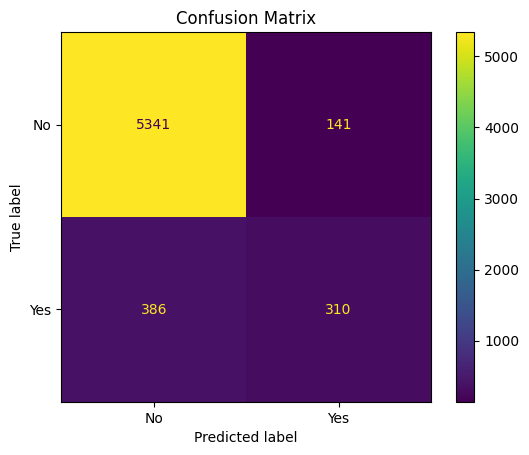


---------------------------------------



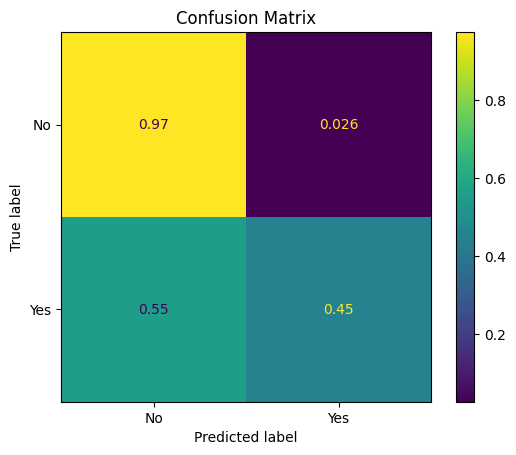

In [19]:
show_confusion_matrix(y_valid, rf_preds)

In [ ]:
# plt.bar(X_train.columns, rf_clf.feature_importances_)

In [20]:
cols_and_scores = list(zip(X_train.columns, rf_clf.feature_importances_))
cols_and_scores.sort(key = lambda x: x[1], reverse=True)
cols_and_scores[:5]

[('duration', 0.28038623970320903),
 ('euribor3m', 0.09995379529108474),
 ('age', 0.07831170951729077),
 ('nremployed', 0.04852712216686068),
 ('campaign', 0.040344553104106874)]

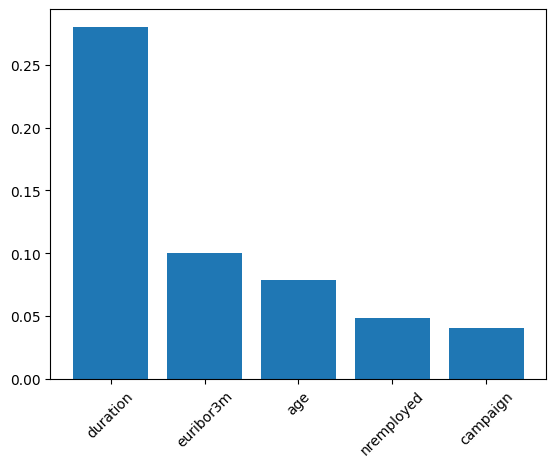

In [21]:
plt.bar([i[0] for i in cols_and_scores][:5], [i[1] for i in cols_and_scores][:5])
plt.xticks(rotation=45)
plt.show()

In [ ]:
# df_copy['pdays'].value_counts()

In [ ]:
# df_copy['pdays'].hist()

## CUSTOMER SEGMENTATION

In [22]:
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN

In [33]:
scores_1 = []
range_values = range(1,10)

In [28]:
df_customer_segmentation = df

In [29]:
df_customer_segmentation.head()

,age,duration,campaign,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0


In [31]:
# Select the most important features along with the output y
df_customer_segmentation = df_customer_segmentation[['y', 'duration', 'euribor3m', 'age', 'nremployed', 'campaign']]

In [39]:
df_customer_segmentation.tail(20)

,y,duration,euribor3m,age,nremployed,campaign
41168,no,144,1.030,38,4963.6,2
41169,no,154,1.030,62,4963.6,5
41170,no,293,1.030,40,4963.6,2
41171,yes,112,1.031,33,4963.6,1
41172,yes,353,1.031,31,4963.6,1
41173,yes,329,1.031,62,4963.6,1
41174,yes,208,1.031,62,4963.6,1
41175,no,180,1.031,34,4963.6,1
41176,no,360,1.031,38,4963.6,1
41177,no,124,1.031,57,4963.6,6


In [37]:
df_customer_segmentation['y'].unique()

array(['no', 'yes'], dtype=object)

In [42]:
df_customer_segmentation.loc[df_customer_segmentation['y'] == 'yes', 'y'] = 1

In [44]:
df_customer_segmentation.loc[df_customer_segmentation['y'] == 'no', 'y'] = 0

In [45]:
df_customer_segmentation.tail()

,y,duration,euribor3m,age,nremployed,campaign
41183,1,334,1.028,73,4963.6,1
41184,0,383,1.028,46,4963.6,1
41185,0,189,1.028,56,4963.6,2
41186,1,442,1.028,44,4963.6,1
41187,0,239,1.028,74,4963.6,3


#### K Means Clustering Using the Elbow Method

In the Elbow method, we are actually varying the number of clusters (K) from 1 – 10. For each value of K, we are calculating WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow.

In [46]:
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df_customer_segmentation)
    scores_1.append(kmeans.inertia_)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

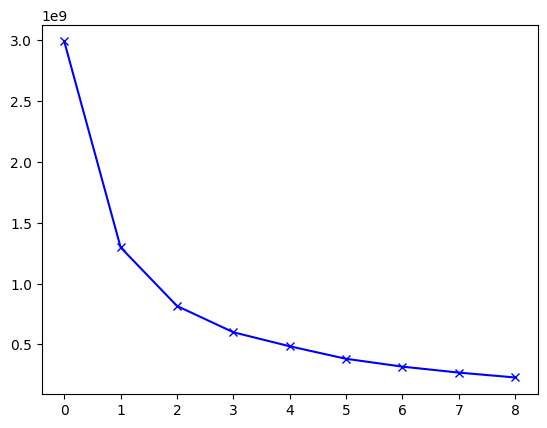

In [47]:
plt.plot(scores_1, 'bx-')

In [49]:
kmeans = KMeans(5)
kmeans.fit(df_customer_segmentation)
labels = kmeans.labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [54]:
kmeans.cluster_centers_.shape

(5, 6)

In [52]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [df_customer_segmentation.columns])
cluster_centers

,y,duration,euribor3m,age,nremployed,campaign
0,0.135419,280.913117,3.295146,40.117609,5150.661877,2.228640
1,0.617978,1842.187266,3.718007,40.314607,5170.079026,2.483146
2,0.550000,995.320122,3.640045,39.664634,5167.824512,2.517073
3,0.023461,106.760176,3.825944,39.979534,5177.277810,2.819985
4,0.286252,556.559531,3.516431,40.092488,5162.075832,2.309897


In [57]:
labels.shape

(41188,)

In [58]:
labels.max()

4

In [59]:
labels.min()

0

In [60]:
y_kmeans = kmeans.fit_predict(df_customer_segmentation)
y_kmeans

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([4, 0, 4, ..., 4, 2, 4], dtype=int32)

In [61]:
df_customer_segmentation_cluster = pd.concat([df_customer_segmentation, pd.DataFrame({'cluster': labels})], axis = 1)
df_customer_segmentation_cluster.head()

,y,duration,euribor3m,age,nremployed,campaign,cluster
0,0,261,4.857,56,5191.0,1,0
1,0,149,4.857,57,5191.0,1,3
2,0,226,4.857,37,5191.0,1,0
3,0,151,4.857,40,5191.0,1,3
4,0,307,4.857,56,5191.0,1,0


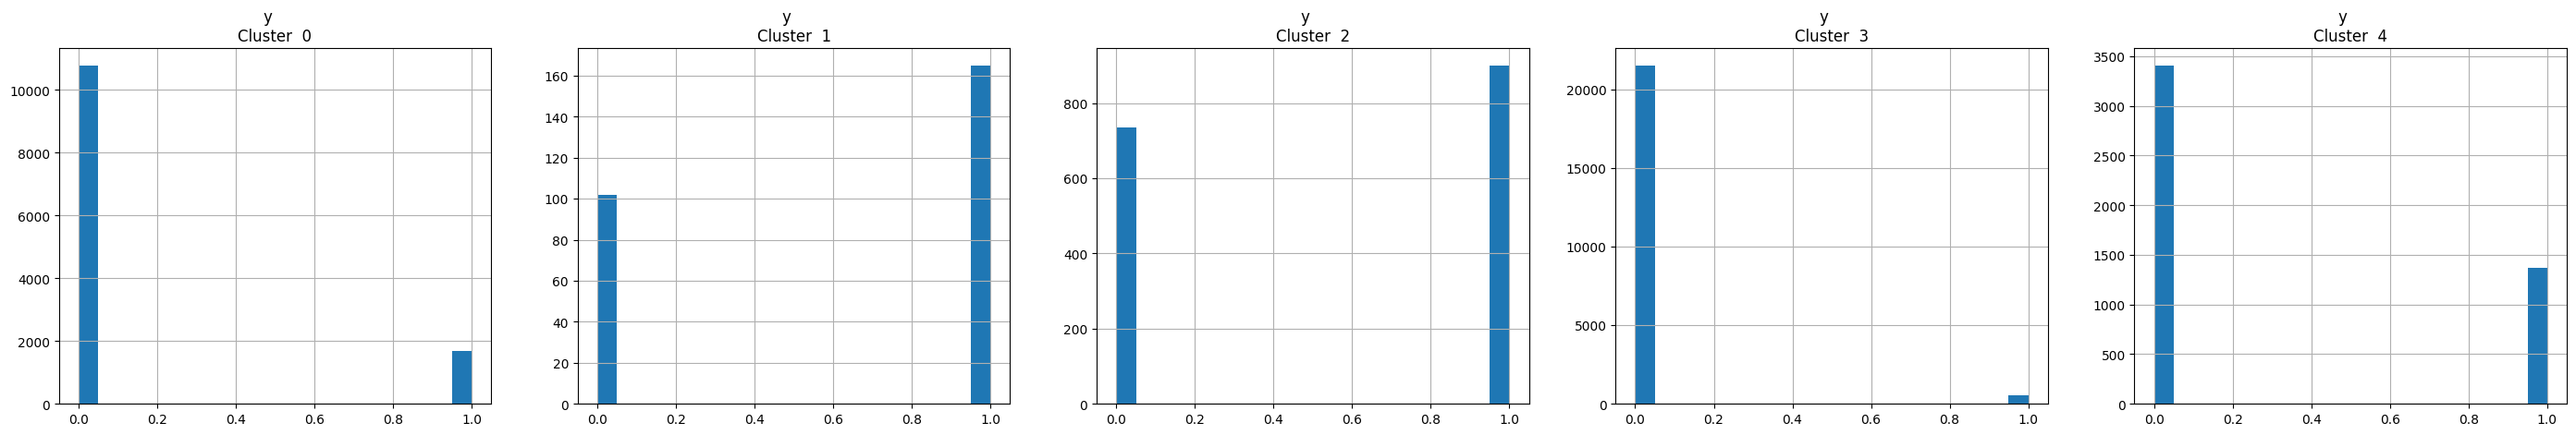

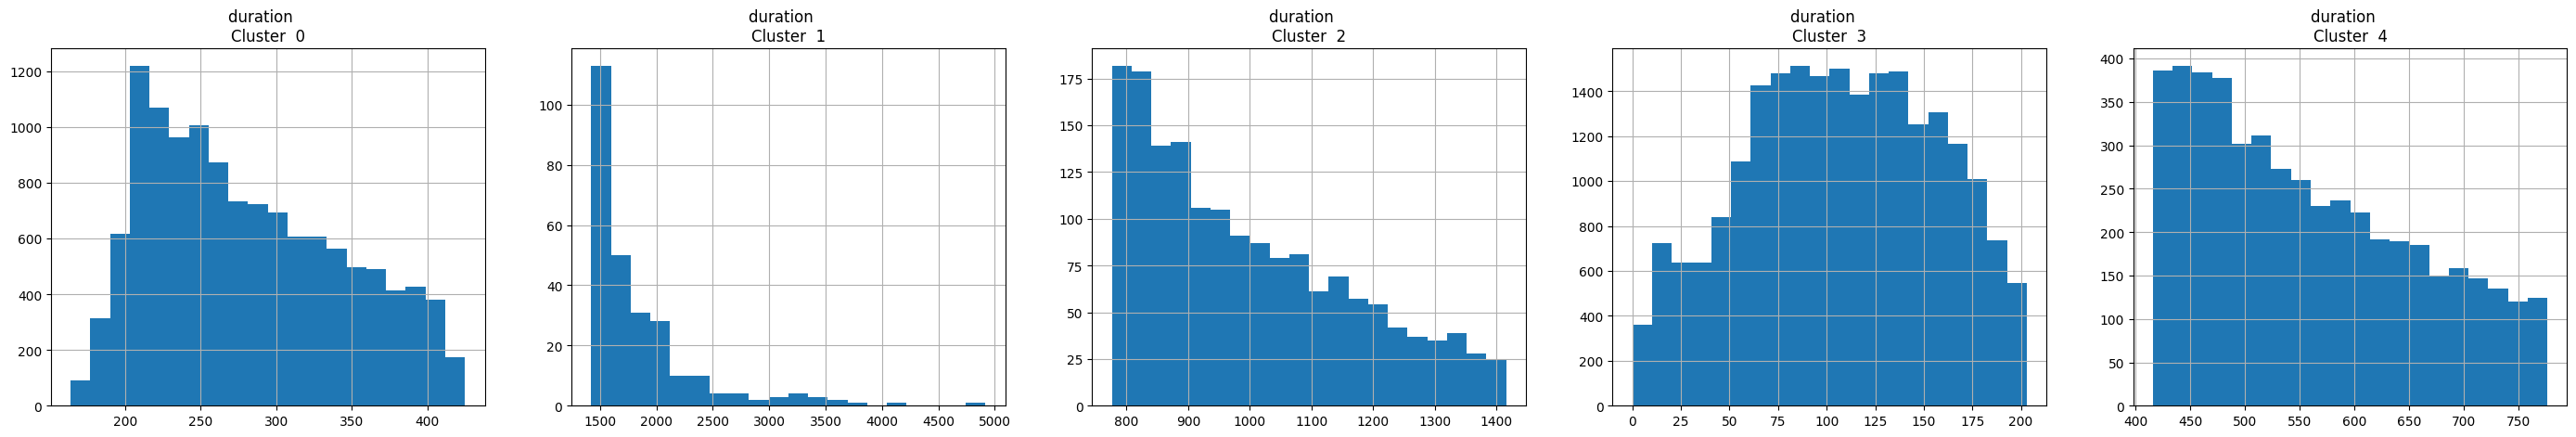

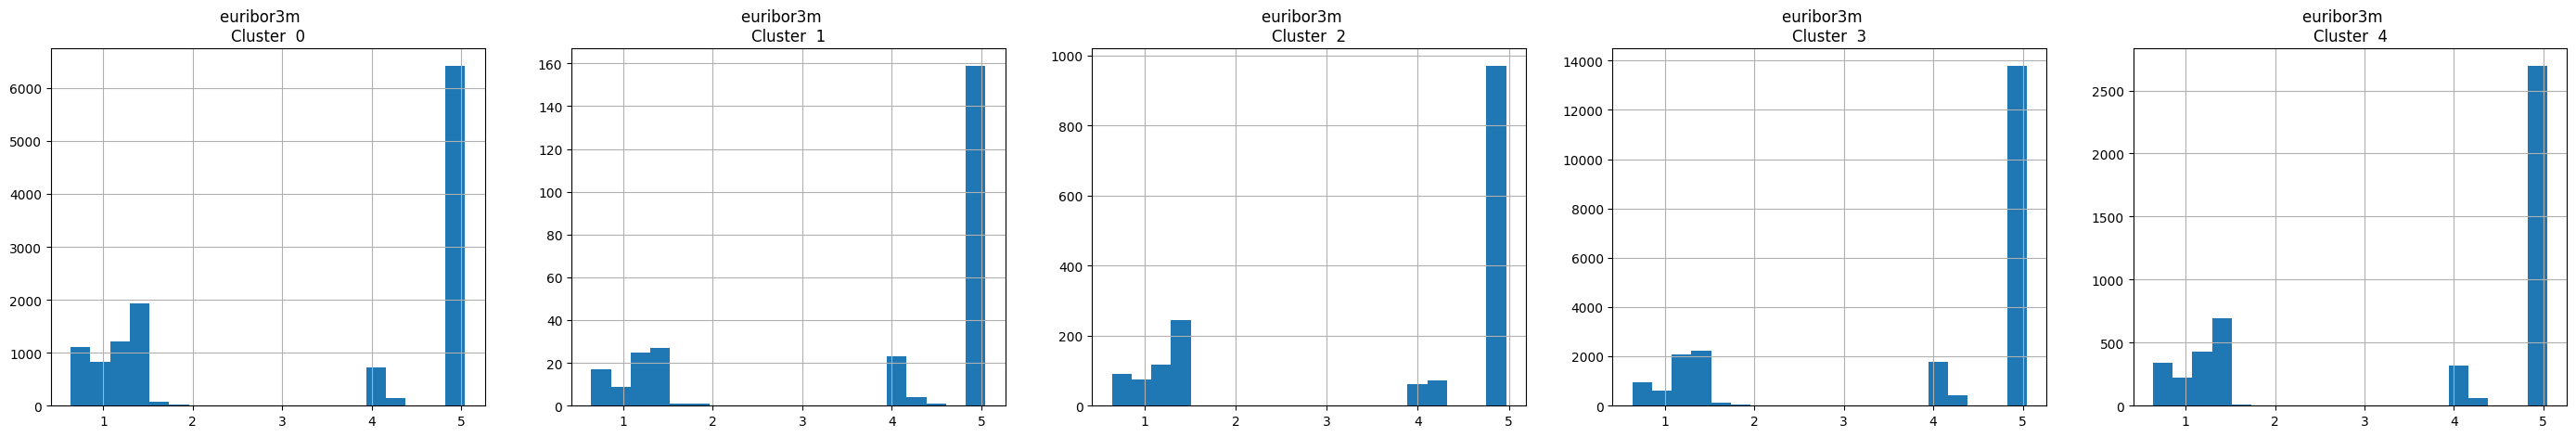

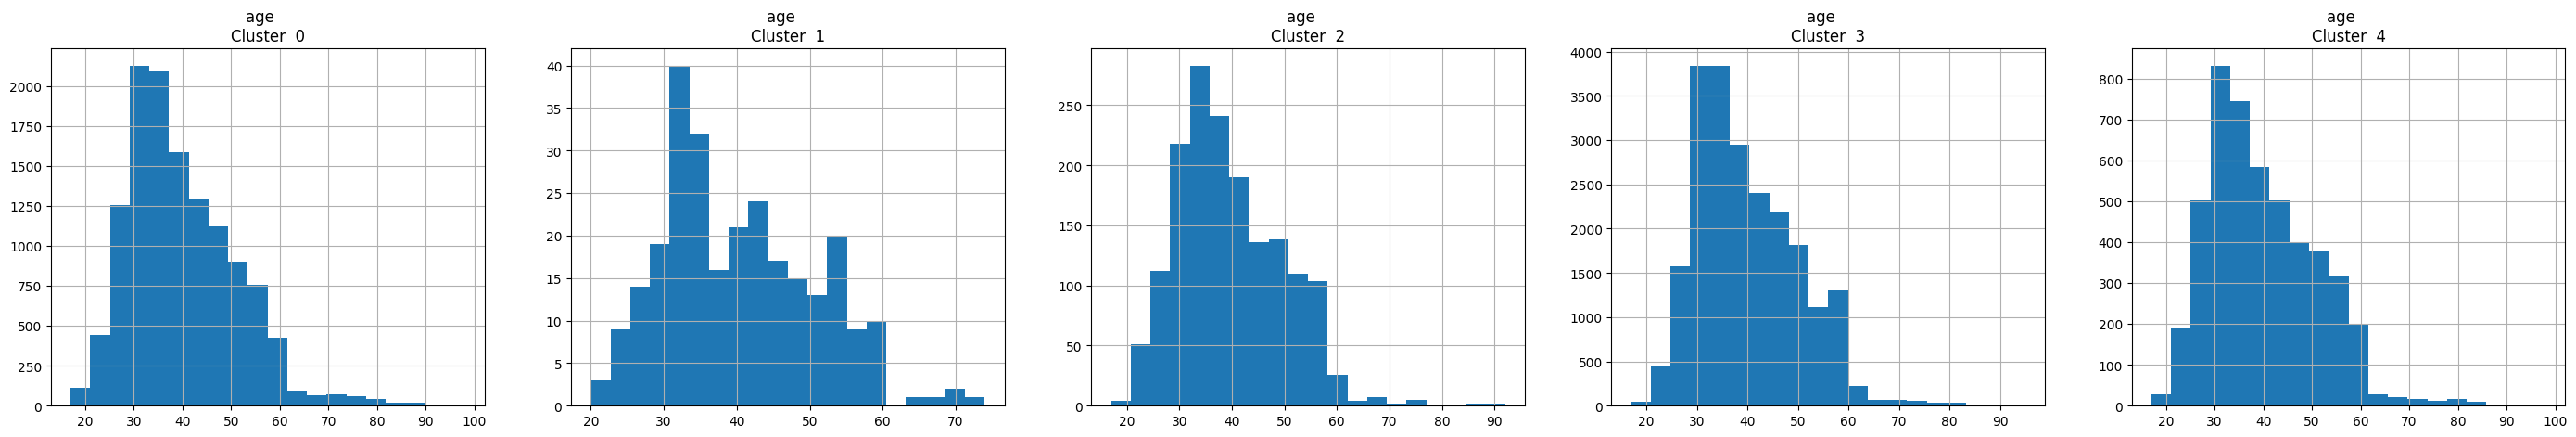

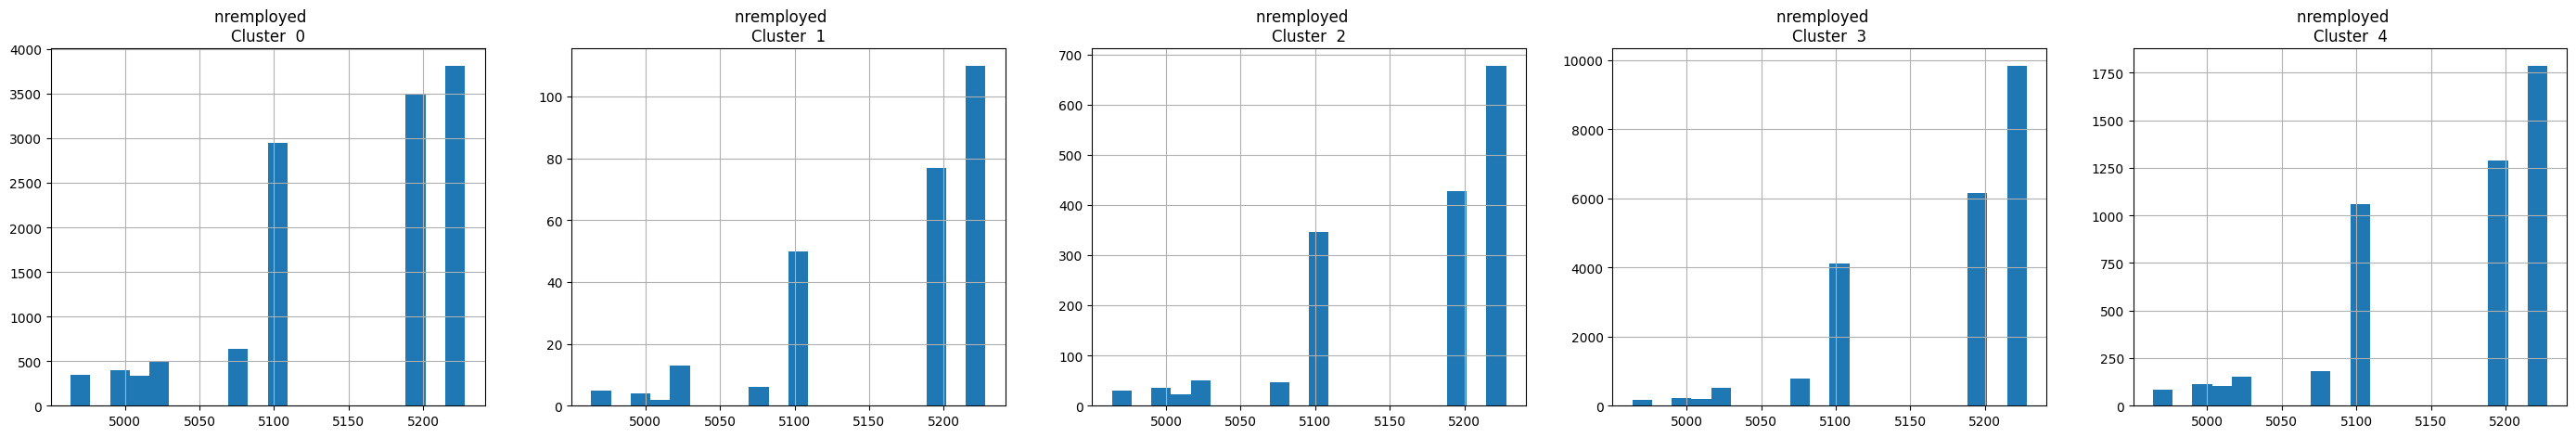

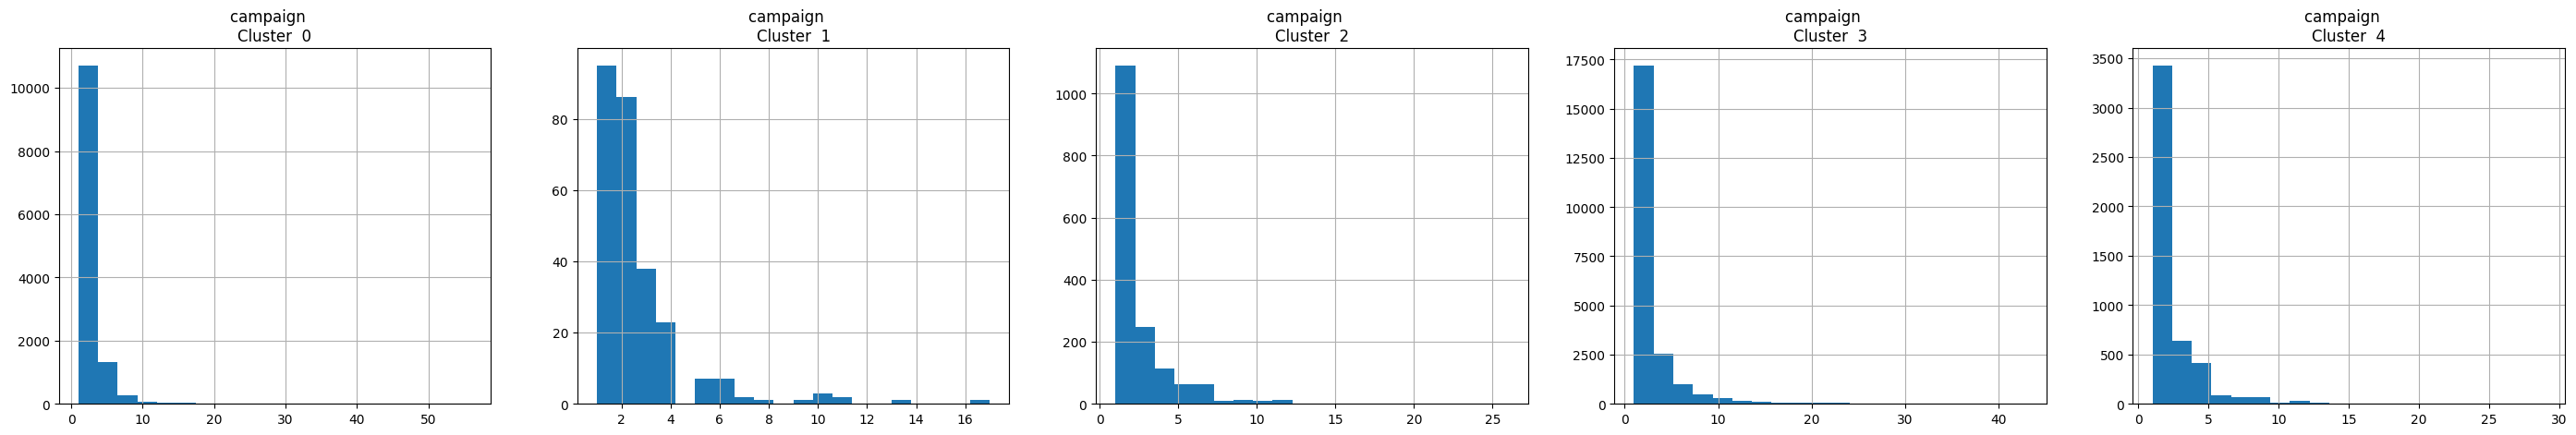

In [62]:
for i in df_customer_segmentation.columns:
    plt.figure(figsize = (35,5))
    for j in range(5):
        plt.subplot(1,5,j+1)
        cluster = df_customer_segmentation_cluster[df_customer_segmentation_cluster['cluster'] == j]
        cluster[i].hist(bins = 20)
        plt.title('{}   \nCluster  {}'.format(i,j))
        
    plt.show()

PCA to analyze the results

In [63]:
from sklearn.decomposition import PCA

In [64]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(df_customer_segmentation)
principal_comp

array([[   2.39149088,  -23.96983053],
       [-109.59827966,  -22.45412495],
       [ -32.60469133,  -23.5467612 ],
       ...,
       [ -66.53115066,  204.40068017],
       [ 186.44732238,  200.95817032],
       [ -16.53708229,  203.76693738]])

In [65]:
# Create a dataframe with the two components
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2'])
pca_df.head()

,pca1,pca2
0,2.391491,-23.969831
1,-109.598280,-22.454125
2,-32.604691,-23.546761
3,-107.597916,-22.525675
4,48.387276,-24.591277


In [66]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,2.391491,-23.969831,0
1,-109.598280,-22.454125,3
2,-32.604691,-23.546761,0
3,-107.597916,-22.525675,3
4,48.387276,-24.591277,0


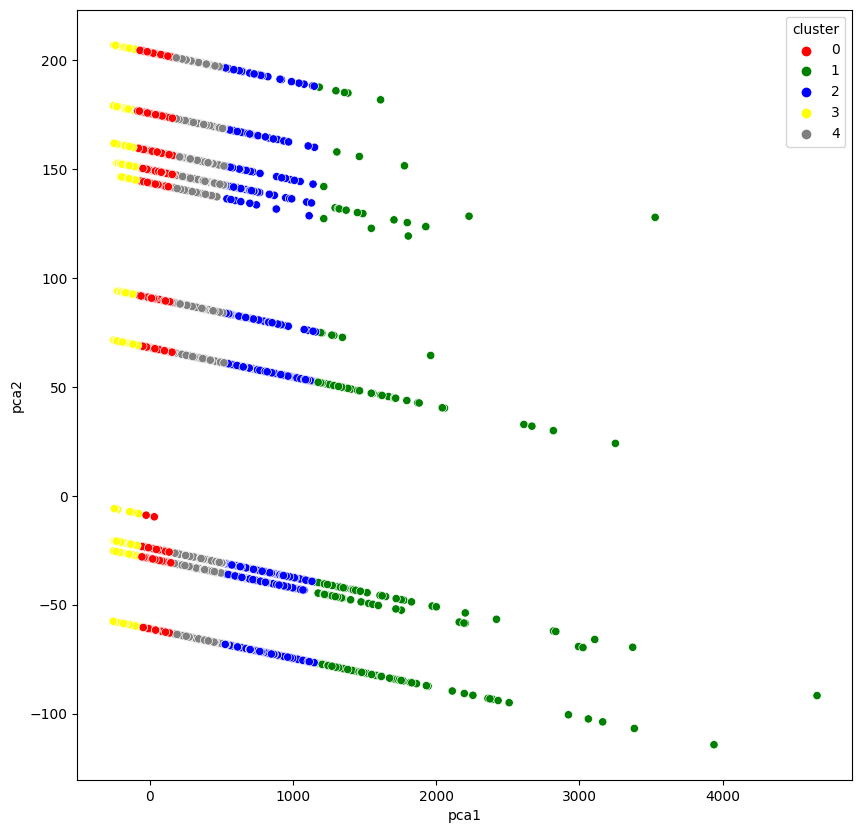

In [67]:
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x='pca1', y='pca2', hue="cluster", data = pca_df, palette = ['red','green','blue','yellow','gray'])